In [1]:
import scipy.io as sio
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw
import math
import pylab
%matplotlib inline
from time import time
# from myipython import cnnModel

Entire image size: 
(1388, 1040)
Well boundary
[722, 234, 1124, 703]
Well size:
(402, 469)
There are 16 cells in total.


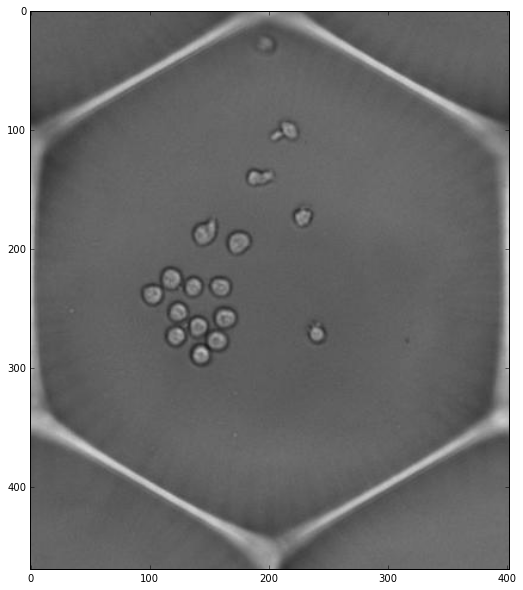

In [2]:
pylab.rcParams['figure.figsize'] = (10.0,10.0)

def loadEntireImage(entire_path):
    img = Image.open(entire_path,'r').convert("RGB")
    return img
      
entireImg = loadEntireImage('./data/test/entireImage/a1.jpeg')
print('Entire image size: ')
print(entireImg.size)
imshow(entireImg)


def loadBoundary(mat_path):
    boundary = sio.loadmat(mat_path)['mwBoundary'][0]
    a = boundary[2]
    b = boundary[0]
    c = boundary[3]
    d = boundary[1]
    return([a,b,c,d])

imshow(Image.new('L', [300,300], color=0))
boundary = loadBoundary('./data/test/boundry.mat')
well = entireImg.crop(boundary)
imshow(well)
print('Well boundary')
print(boundary)
print('Well size:')
print(well.size)

sizeX = well.size[0]
sizeY = well.size[1]

def loadCoordinate(filename,index):
    det = sio.loadmat(filename)
    table = det['detection'][0][index]
    arrayX = []
    arrayY = []
    for i in range(table.shape[0]):
        arrayX.append(table[i][0])
        arrayY.append(table[i][1])
    return arrayX,arrayY
        

def printCoordinate(X,Y,img):
    draw = ImageDraw.Draw(img)
    for i in range(len(X)):
        draw.ellipse((X[i]-2,Y[i]-2,X[i]+2,Y[i]+2),fill = 'yellow', outline ='yellow')
    imshow(img)
    
X,Y = loadCoordinate('./data/test/det.mat',0)
wellDraw = well
imshow(well)

print('There are '+str(len(X))+" cells in total.")

# printCoordinate(X,Y,wellDraw)

In [3]:
from numpy import random

def chooseRandomCrop(img,a,b):
    sizeX = img.size[0]
    sizeY = img.size[1]
    randomX = random.randint(0,sizeX-a)
    randomY = random.randint(0,sizeY-b)
    bound = [randomX,randomY,randomX+a,randomY+b]
    crop = img.crop(bound)
    return crop,bound

def rgbToInteger(r,g,b):
    return r*256*256+g*256+b

def countCell(coordinateName,bound,cellSize,index):
    count =0
    X,Y = loadCoordinate(coordinateName,index)
    for m in range(len(X)):
        if ((bound[0]+cellSize<X[m]) and (bound[2]-cellSize>X[m]) and (bound[1]+cellSize<Y[m]) and (bound[3]-cellSize>Y[m])):
            count = count+1
    return count
    

def generateTrainSetBalanced(entireImgPath,boundaryPath,coordinatePath,a,b,cellSize,numberEachImage,numberOfImage):
    
    boundary = loadBoundary(boundaryPath)  
    labelOneBoundList = []
    trainData = []
    trainLabelClassifier = []
    trainLabelCount=[]
    labelOneBoundList = []
    labelOneCountList = []
    allBound = []
    halfNumber = math.floor(numberEachImage/2)
#     labelOneNum=0
#     labelZeroNum=0
    
    
    for imageNumber in range(numberOfImage):
        entireImg = loadEntireImage(entireImgPath+str(imageNumber+1)+".jpeg")
        img = entireImg.crop(boundary)      
        labelOneNum=0
        labelZeroNum=0
        if(imageNumber%10==0):
            print(entireImgPath+str(imageNumber+1)+".jpeg")
        while(True):
            rgb=[]
            crop,bound = chooseRandomCrop(img,a,b)
            count = countCell(coordinatePath,bound,cellSize,imageNumber)
            allBound.append(bound)
            for k in range(len(crop.getdata())):
                rgb.append(rgbToInteger(crop.getdata()[k][0],crop.getdata()[k][1],crop.getdata()[k][2]))  
            if(count>0 and labelOneNum<halfNumber):
                labelOneNum+=1
                label = 1             
                trainLabelClassifier.append(label)
                trainData.append(rgb)
                trainLabelCount.append(count)
                labelOneCountList.append(count)
                labelOneBoundList.append(bound)
            elif(count==0 and labelZeroNum<halfNumber):
                labelZeroNum+=1
                label=0
                trainLabelClassifier.append(label)
                trainData.append(rgb)
                trainLabelCount.append(count)   
            elif(labelOneNum==halfNumber and labelZeroNum==halfNumber):
                break
            
    print("Generate balanced train set.")
    print(str(len(labelOneCountList))+" in "+str(numberEachImage*numberOfImage)+" has label.") 
    return trainData,trainLabelClassifier,trainLabelCount,labelOneCountList,labelOneBoundList,allBound
     
    
    
print('finish')

finish


In [4]:
import os
import sys
import pickle

import numpy
from PIL import Image

import theano
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.signal import downsample
import math



#[1]
def load_params(params_file):
    f=open(params_file,'rb')
    layer0_params=pickle.load(f)
    layer1_params=pickle.load(f)
    layer2_params=pickle.load(f)
    layer3_params=pickle.load(f)
    f.close()
    return layer0_params,layer1_params,layer2_params,layer3_params


def load_data(Data,Label):

    test_data = numpy.array(Data)
    test_label = numpy.array(Label)
    return test_data,test_label


class LogisticRegression(object):
    def __init__(self, input, params_W,params_b,n_in, n_out):
        self.W = params_W
        self.b = params_b
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        if y.dtype.startswith('int'):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()
            
            
            
class LinearRegression(object):
    def __init__(self, input, params_W,params_b,n_in, n_out):
        self.W = params_W
        self.b = params_b
        self.p_y_given_x = T.dot(input, self.W) + self.b
        self.y_pred = self.p_y_given_x[:,0]
#         self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        self.params = [self.W, self.b]

    def linear_likelihood(self, y,number):
#         return T.square(y-self.y_pred)
        return T.sum(T.pow(self.y_pred-y,2))/(2*number)

    def errors(self, y):
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        if y.dtype.startswith('int'):
            return T.sum(T.pow(self.y_pred-y,2))/(2*800)
#             return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()


class HiddenLayer(object):
    def __init__(self, input, params_W,params_b, n_in, n_out,
                 activation=T.tanh):
        self.input = input
        self.W = params_W
        self.b = params_b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        self.params = [self.W, self.b]

	
#卷积+采样层（conv+maxpooling）
class LeNetConvPoolLayer(object):
    def __init__(self,  input,params_W,params_b, filter_shape, image_shape, poolsize=(2, 2)):
        assert image_shape[1] == filter_shape[1]
        self.input = input
        self.W = params_W
        self.b = params_b
        # 卷积
        conv_out = conv.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )
        # 子采样
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.params = [self.W, self.b]

/Users/jizhizili/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
def use_CNN(dataSet,labelSet,params_file,choice,printSwitch):   
    fullyOutputNumber = 10
    nkerns=[5, 10]
#     nkerns=[10, 20]
    #load data
    # faces,label=load_data(dataset)
    data,label = load_data(dataSet,labelSet)
    data_num = data.shape[0]   #how many data
    
    #load parameter
    #[2]
    layer0_params,layer1_params,layer2_params,layer3_params=load_params(params_file)


    x = T.matrix('x')  #用变量x表示输入的人脸数据，作为layer0的输入

    ######################
    #用读进来的参数初始化各层参数W、b
    ######################
    layer0_input = x.reshape((data_num, 1, 50,50)) 
    layer0 = LeNetConvPoolLayer(
        input=layer0_input,
        params_W=layer0_params[0],
        params_b=layer0_params[1],
        image_shape=(data_num, 1, 50,50),
        filter_shape=(nkerns[0], 1, 5,5),
        poolsize=(2, 2)
    )

    #[3]
    layer1 = LeNetConvPoolLayer(
        input=layer0.output,
        params_W=layer1_params[0],
        params_b=layer1_params[1],
        image_shape=(data_num, nkerns[0], 23,23),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )

    layer2_input = layer1.output.flatten(2)



    layer2 = HiddenLayer(
        input=layer2_input,
        params_W=layer2_params[0],
        params_b=layer2_params[1],
        n_in=nkerns[1] * 9 * 9,
        n_out= fullyOutputNumber,      
        activation=T.tanh
    )

    if(choice=='logistic_zeroOne'):
        layer3 = LogisticRegression(input=layer2.output, params_W=layer3_params[0],params_b=layer3_params[1],n_in= fullyOutputNumber, n_out=2)
    elif(choice=='logistic_count'):
        layer3 = LogisticRegression(input=layer2.output, params_W=layer3_params[0],params_b=layer3_params[1],n_in=fullyOutputNumber, n_out=16)
    elif(choice=="linear_count"):
        layer3 = LinearRegression(input=layer2.output,params_W=layer3_params[0],params_b=layer3_params[1],n_in=fullyOutputNumber, n_out=1)  

     
     
    #定义theano.function，让x作为输入，layer3.y_pred（即预测的类别）作为输出
    f = theano.function(
        [x],    #funtion 的输入必须是list，即使只有一个输入
        layer3.y_pred
    )
    
    #预测的类别pred
    pred = f(data)

    

    #将预测的类别pred与真正类别label对比，输出错分的图像
    wrongList = []
#     plt.plot(pred,label)

    for i in range(data_num):
        if(label[i]!=math.floor(pred[i])):
            wrongList.append(i)
            if(printSwitch==True):
                print('picture: %i is %i, mis-predicted as  %i' %(i, label[i], pred[i]))
    print(str(len(wrongList))+" in "+str(len(label))+" has been predicted wrong")
    print("predict accuracy: {:.2f}%".format((len(label)-len(wrongList))/len(label)*100))
    return label, pred, wrongList
        
    
print('finish')
        

finish


In [6]:
start = time()

entirePath = './data/test/entireImage/a'
boudaryPath = './data/test/boundry.mat'
detPath = './data/test/det.mat'

trainSetData,trainSetLabel,trainSetCountLabel,labelOneCount,labelOneBound,allBound = generateTrainSetBalanced(entirePath,boudaryPath,detPath,50,50,5,10,100)

print('Finish running in {:.2f} seconds.'.format(time()-start))

./data/test/entireImage/a1.jpeg
./data/test/entireImage/a11.jpeg
./data/test/entireImage/a21.jpeg
./data/test/entireImage/a31.jpeg
./data/test/entireImage/a41.jpeg
./data/test/entireImage/a51.jpeg
./data/test/entireImage/a61.jpeg
./data/test/entireImage/a71.jpeg
./data/test/entireImage/a81.jpeg
./data/test/entireImage/a91.jpeg
Generate balanced train set.
500 in 1000 has label.
Finish running in 55.60 seconds.


## Linear Regression for Cell Counting

500 in 1000 has been predicted wrong
predict accuracy: 50.00%


ValueError: num must be 1 <= num <= 9, not 10

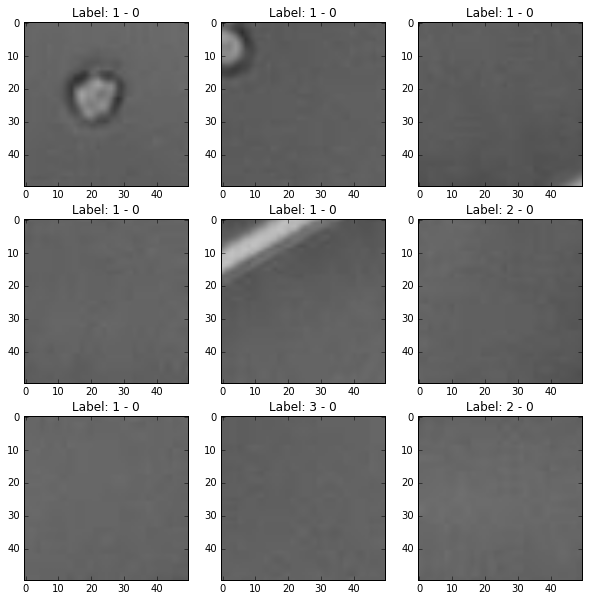

In [10]:
y_true,y_pred,wrongID = use_CNN(trainSetData, trainSetCountLabel,'./params/linear_count_params.pkl','linear_count',False)

# print(wrongID)

f = pylab.figure()
pylab.rcParams['figure.figsize'] = (10,10)

count=1
for i in wrongID:
    f.add_subplot(3,3,count)
    count= count+1
    if(count>10):
        break
    pylab.imshow(well.crop(allBound[i]))
    pylab.title("Label: "+str(y_true[i])+" - "+str(math.floor(y_pred[i])))
#     pylab.title("Classifier: "+str(trainSetLabel[i]))
    
    
    

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import pylab
from matplotlib.pyplot import imshow
from matplotlib.pyplot import savefig

from sklearn.metrics import explained_variance_score
from pydoc import help
from scipy.stats.stats import pearsonr
MSE = mean_squared_error(y_true, y_pred)
print(MSE)
PEAR = pearsonr(y_true,y_pred)
print(PEAR)

pylab.rcParams['figure.figsize'] = (10.0,10.0)
img = plt.scatter(y_true,y_pred,  color='black')    
#         plt.xticks(())
#         plt.yticks(())

plt.ylabel('predict number')
plt.xlabel('true number')
plt.title('Two Convolutional Layer')
plt.axis('on')



fig = plt.gcf()

fig.savefig('./resultFig/1_2.png',dpi=100)
plt.show(img)


# plt.savefig('./resultFig/1_2.jpg')



NameError: name 'y_true' is not defined

## Logistic Regression for Classification

76 in 1000 has been predicted wrong
predict accuracy: 92.40%
[35, 39, 88, 94, 128, 131, 152, 157, 158, 174, 187, 198, 207, 210, 222, 223, 273, 276, 282, 284, 288, 291, 300, 330, 367, 389, 422, 440, 442, 460, 468, 536, 556, 558, 607, 616, 620, 636, 640, 650, 657, 661, 663, 686, 702, 705, 715, 721, 724, 732, 734, 759, 764, 765, 769, 770, 771, 779, 796, 800, 818, 822, 826, 834, 844, 881, 887, 911, 919, 921, 930, 965, 974, 982, 985, 992]


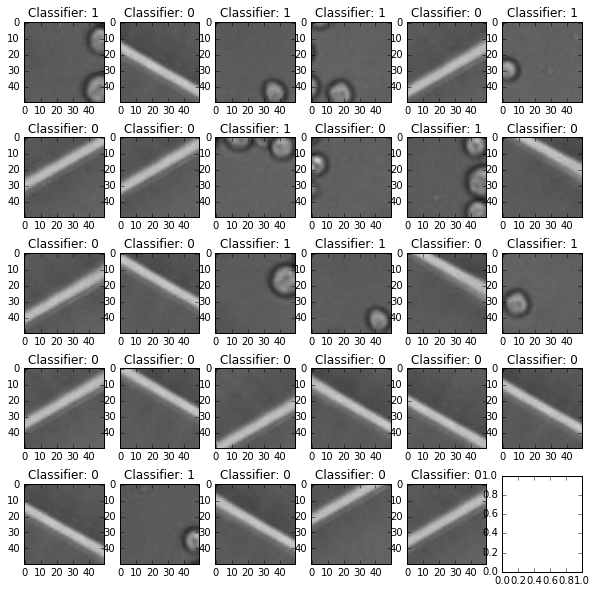

In [27]:
y_true,y_pred,wrongID = use_CNN(trainSetData, trainSetLabel,'./params/logistic_zeroOne_params.pkl','logistic_zeroOne',False)

print(wrongID)

f = pylab.figure()
pylab.rcParams['figure.figsize'] = (10,10)

count=1
for i in wrongID:
    f.add_subplot(5,6,count)
    count= count+1
    if(count>30):
        break
    pylab.imshow(well.crop(allBound[i]))
    pylab.title("Classifier: "+str(trainSetCountLabel[i]))
#     pylab.title("Classifier: "+str(trainSetLabel[i]))
    
    
    

## Logistic Regression for regression

255 in 1000 has been predicted wrong
predict accuracy: 74.50%
[7, 12, 14, 18, 26, 27, 32, 34, 35, 39, 50, 55, 65, 75, 87, 88, 100, 108, 110, 115, 119, 124, 128, 139, 142, 148, 152, 157, 174, 183, 198, 207, 210, 221, 222, 223, 233, 264, 271, 273, 282, 283, 284, 287, 288, 291, 294, 300, 314, 327, 330, 332, 357, 363, 367, 375, 378, 385, 389, 400, 412, 422, 428, 440, 442, 452, 457, 460, 466, 468, 469, 474, 485, 490, 492, 503, 508, 510, 521, 522, 525, 536, 547, 549, 552, 553, 556, 558, 588, 603, 606, 608, 610, 612, 616, 617, 618, 619, 621, 622, 623, 626, 629, 630, 631, 635, 636, 637, 638, 640, 641, 642, 643, 644, 651, 653, 654, 656, 659, 661, 662, 664, 666, 667, 675, 676, 678, 682, 687, 691, 698, 701, 706, 708, 709, 713, 714, 715, 718, 719, 721, 725, 727, 731, 733, 734, 735, 737, 739, 740, 741, 743, 745, 748, 757, 758, 759, 770, 771, 773, 776, 778, 782, 787, 790, 791, 799, 801, 802, 804, 805, 807, 808, 809, 810, 811, 813, 814, 818, 823, 825, 826, 827, 828, 830, 832, 834, 839, 843, 844, 848,

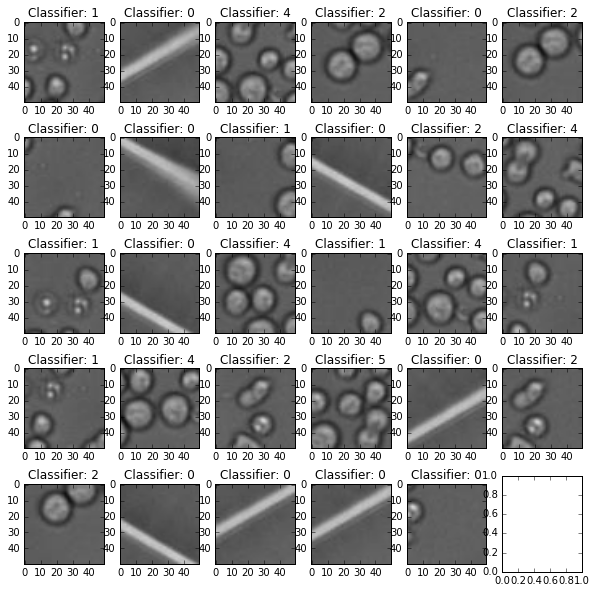

In [28]:
y_true,y_pred,wrongID = use_CNN(trainSetData, trainSetCountLabel,'./params/logistic_count_params.pkl','logistic_count',False)


print(wrongID)

f = pylab.figure()
pylab.rcParams['figure.figsize'] = (10,10)

count=1
for i in wrongID:
    f.add_subplot(5,6,count)
    count= count+1
    if(count>30):
        break
    pylab.imshow(well.crop(allBound[i]))
    pylab.title("Classifier: "+str(trainSetCountLabel[i]))
#     pylab.title("Classifier: "+str(trainSetLabel[i]))
    
    
    